In [1]:
import numpy as np
import laserhockey.hockey_env as h_env
import gymnasium as gym
from importlib import reload
import time

In [7]:
np.set_printoptions(suppress=True)

In [8]:
reload(h_env)

/Users/nicolasschmitt/Desktop/RLPowerPucks/venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/Users/nicolasschmitt/Desktop/RLPowerPucks/venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


<module 'laserhockey.hockey_env' from '/Users/nicolasschmitt/Desktop/RLPowerPucks/laser-hockey-env/laserhockey/hockey_env.py'>

# Normal Game Play

In [9]:
env = h_env.HockeyEnv()

have a look at the initialization condition: alternating who starts and are random in puck position

In [10]:
obs, info = env.reset()
obs_agent2 = env.obs_agent_two()
_ = env.render()

2023-06-29 22:11:06.579 Python[47164:774206] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/qj/dbk90w_j1h9fb4xkshzhqsj40000gn/T/org.python.python.savedState


one episode with random agents

In [10]:
obs, info = env.reset()
obs_agent2 = env.obs_agent_two()

for _ in range(600):
    env.render(mode="human")
    a1 = np.random.uniform(-1,1,4)
    a2 = np.random.uniform(-1,1,4)    
    obs, r, d, t, info = env.step(np.hstack([a1,a2]))    
    obs_agent2 = env.obs_agent_two()
    if d: break

2023-07-03 10:36:09.382 Python[38237:787766] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/qj/dbk90w_j1h9fb4xkshzhqsj40000gn/T/org.python.python.savedState


Without rendering, it runs much faster

"info" dict contains useful proxy rewards and winning information

In [11]:
info

{'winner': -1,
 'reward_closeness_to_puck': -0.18192203047818525,
 'reward_touch_puck': 0.0,
 'reward_puck_direction': -0.0021062083435058596}

Winner == 0: draw

Winner == 1: you (left player)

Winner == -1: opponent wins (right player)

In [12]:
env.close()

# Train Shooting

In [13]:
env = h_env.HockeyEnv(mode=h_env.HockeyEnv.TRAIN_SHOOTING)

In [14]:
o, info = env.reset()
_ = env.render()

for _ in range(50):
    env.render()
    a1 = [1,0,0,1] # np.random.uniform(-1,1,4)
    a2 = [0,0.,0,0] 
    obs, r, d, _ , info = env.step(np.hstack([a1,a2]))    
    obs_agent2 = env.obs_agent_two()
    if d: break

In [16]:
env.close()

# Train DEFENDING

In [17]:
env = h_env.HockeyEnv(mode=h_env.HockeyEnv.TRAIN_DEFENSE)

In [18]:
o, info = env.reset()
_ = env.render()

for _ in range(60):
    env.render()
    a1 = [0.1,0,0,1] # np.random.uniform(-1,1,3)
    a2 = [0,0.,0,0] 
    obs, r, d,_, info = env.step(np.hstack([a1,a2]))
    print(r)
    obs_agent2 = env.obs_agent_two()
    if d: break

-0.47664420829955806
-0.30458029780810075
-0.16886355501905623
-0.07218045224487296
0
0
0
0
0
0
0
0
0
0
0
0
10


In [19]:
env.close()

# Using discrete actions

In [20]:
import random

In [21]:
env = h_env.HockeyEnv(mode=h_env.HockeyEnv.TRAIN_SHOOTING)

In [22]:
env.reset()
for _ in range(200):
    env.render()
    a1_discrete = random.randint(0,7)
    a1 = env.discrete_to_continous_action(a1_discrete)
    a2 = [0,0.,0,0 ] 
    obs, r, d, _, info = env.step(np.hstack([a1,a2]))    
    obs_agent2 = env.obs_agent_two()
    if d: break

In [23]:
env.close()

# Hand-crafted Opponent

In [24]:
env = h_env.HockeyEnv()

In [25]:
o, info = env.reset()
_ = env.render()
player1 = h_env.BasicOpponent(weak=False)
player2 = h_env.BasicOpponent()

In [26]:
obs_buffer = []
reward_buffer=[]
obs, info = env.reset()
obs_agent2 = env.obs_agent_two()
for _ in range(250):
    env.render()
    a1 = player1.act(obs)
    a2 = player2.act(obs_agent2)
    obs, r, d, _, info = env.step(np.hstack([a1,a2]))    
    obs_buffer.append(obs)
    reward_buffer.append(r)
    obs_agent2 = env.obs_agent_two()
    if d: break
obs_buffer = np.asarray(obs_buffer)
reward_buffer = np.asarray(reward_buffer)

In [27]:
np.mean(obs_buffer,axis=0)

array([-2.49629502, -0.0586847 ,  0.4360792 , -0.64734676,  0.04102941,
       -0.59036466,  1.5832769 ,  0.10244257, -0.05141185, -0.33838601,
        0.50691326, -0.34886118,  0.14473172,  0.61647134,  9.29640594,
       -0.97363846,  3.        ,  0.        ])

In [28]:
np.std(obs_buffer,axis=0)

array([ 0.62537854,  0.05523034,  0.39989168,  5.51117787,  1.14438098,
        3.51572591,  0.81724155,  0.16131918,  0.10530481,  7.68719427,
        0.78177218,  0.52136534,  2.00776886,  1.08203802, 10.06511193,
       15.40468253,  4.98569382,  0.        ])

If you want to use a fixed observation scaling, this might be a reasonable choice

In [29]:
scaling = [ 1.0,  1.0 , 0.5, 4.0, 4.0, 4.0,  
            1.0,  1.0,  0.5, 4.0, 4.0, 4.0,  
            2.0, 2.0, 10.0, 10.0, 4,0 ,4,0]

In [30]:
#import pylab as plt
# import plt from matplotlib
from matplotlib import pyplot as plt

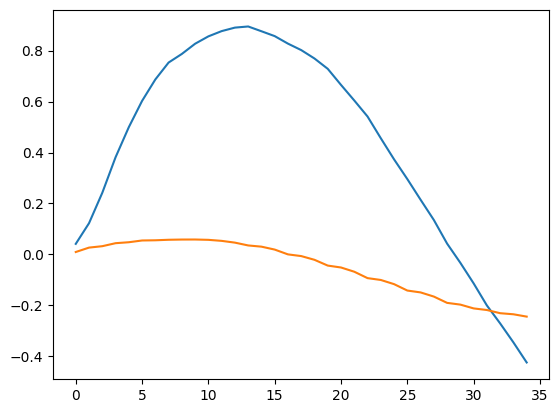

In [31]:
plt.plot(obs_buffer[:,2])
plt.plot(obs_buffer[:,8])

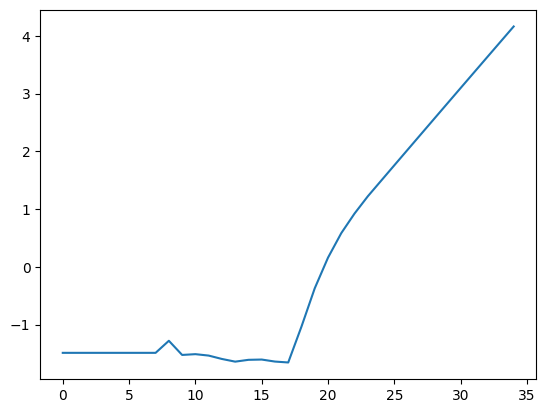

In [32]:
plt.plot(obs_buffer[:,12])

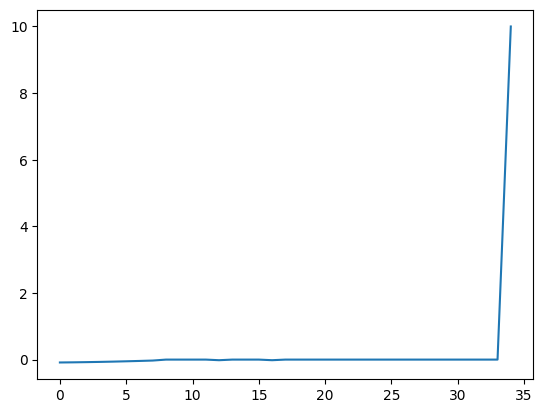

In [33]:
plt.plot(reward_buffer[:])

In [34]:
np.sum(reward_buffer)

9.468896397080266

In [35]:
env.close()

# Human Opponent

In [42]:
env = h_env.HockeyEnv()

In [43]:
player1 = h_env.HumanOpponent(env=env, player=1)
player2 = h_env.BasicOpponent()


Human Controls:
 left:			left arrow key left
 right:			arrow key right
 up:			arrow key up
 down:			arrow key down
 tilt clockwise:	w
 tilt anti-clockwise:	s
 shoot :	space


In [44]:
player1 = h_env.BasicOpponent()
player2 = h_env.HumanOpponent(env=env, player=2)


Human Controls:
 left:			left arrow key left
 right:			arrow key right
 up:			arrow key up
 down:			arrow key down
 tilt clockwise:	w
 tilt anti-clockwise:	s
 shoot :	space


In [45]:
obs, info = env.reset()

env.render()
time.sleep(1)
obs_agent2 = env.obs_agent_two()
for _ in range(100):
    time.sleep(0.2)
    env.render()
    a1 = player1.act(obs) 
    a2 = player2.act(obs_agent2)
    obs, r, d, _, info = env.step(np.hstack([a1,a2]))    
    obs_agent2 = env.obs_agent_two()
    if d: break

: 

In [40]:
env.close()